In [1]:
from __future__ import division, print_function

import collections
import csv
import datetime
import xml.etree.ElementTree as ET

import numpy as np
import pandas as pd

from datetime import datetime, timedelta
from scipy.interpolate import CubicSpline
import matplotlib.pyplot as plt

import torch
from torch.utils.data import DataLoader, TensorDataset
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.metrics import root_mean_squared_error
import pickle
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [2]:
def prepare_dataset(segments, ph, history):
    '''
    ph = 6, 30 minutes ahead
    ph = 12, 60 minutes ahead
    '''
    features_list = []
    labels_list = []
    raw_glu_list = []
    
    # Iterate over each segment
    for segment_name, segment_df in segments.items():
        # Ensure all columns are of numeric type
        segment_df['carb_effect'] = pd.to_numeric(segment_df['carb_effect'], errors='coerce')
        segment_df['steps'] = pd.to_numeric(segment_df['steps'], errors='coerce')
        segment_df['steps'] = segment_df['steps'] 
        segment_df['bolus_effect'] = pd.to_numeric(segment_df['bolus_effect'], errors='coerce')

        # Fill NaNs that might have been introduced by conversion errors
        segment_df.fillna(0, inplace=True)

        # Maximum index for creating a complete feature set
        max_index = len(segment_df) - (history-1+ph+1)  # Subtracting 22 because we need to predict index + 21 and need index + history-1 to exist
        
        # Iterate through the data to create feature-label pairs
        for i in range(max_index + 1):
            # Extracting features from index i to i+history-1
            features = segment_df.loc[i:i+history-1, ['glucose_value', 'carb_effect', 'bolus_effect', 'steps']] # .values.flatten() # 'carb_effect', 'bolus_effect', 'steps'
            # Extracting label for index i+21
            # Do the label transform
            label = segment_df.loc[i+history-1+ph, 'glucose_value'] - segment_df.loc[i+history-1, 'glucose_value']
            
            raw_glu_list.append(segment_df.loc[i+history-1+ph, 'glucose_value'])
            features_list.append(features)
            labels_list.append(label)
            
    print("len of features_list " + str(len(features_list)))
    print("len of labels_list " + str(len(labels_list)))
    # new_labels_list = label_delta_transform(labels_list)    
    # print("after label transform. the len of label list "+str(len(new_labels_list)))    
    return features_list, labels_list, raw_glu_list

In [3]:
import torch
import torch.nn as nn
import torch.optim as optim


class StackedLSTM(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, output_size, dropout_prob):
        super(StackedLSTM, self).__init__()
        
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        
        # First LSTM layer
        self.lstm1 = nn.LSTM(input_size, hidden_size, num_layers=1, batch_first=True).to(device)
        
        # Dropout layer
        self.dropout = nn.Dropout(dropout_prob).to(device)
        
        # Second LSTM layer
        self.lstm2 = nn.LSTM(hidden_size, hidden_size, num_layers=1, batch_first=True).to(device)
        
        # Fully connected layers
        self.fc1 = nn.Linear(hidden_size, 512).to(device)
        self.fc2 = nn.Linear(512, 128).to(device)
        self.fc3 = nn.Linear(128, output_size).to(device)
        
        # Activation functions
        self.relu = nn.ReLU()
        
    
    def forward(self, x):
        batch_size = x.size(0)  # Get the batch size from the input tensor

        # Initialize hidden and cell state for the first LSTM layer
        h0 = torch.zeros(1, batch_size, self.hidden_size).to(x.device)
        c0 = torch.zeros(1, batch_size, self.hidden_size).to(x.device)
        
        # First LSTM layer
        out, (hn, cn) = self.lstm1(x, (h0, c0))
        
        # Dropout layer
        out = self.dropout(out)
        
        # Initialize hidden and cell state for the second LSTM layer
        h1 = torch.zeros(1, batch_size, self.hidden_size).to(x.device)
        c1 = torch.zeros(1, batch_size, self.hidden_size).to(x.device)
        
        # Second LSTM layer
        out, (hn, cn) = self.lstm2(out, (h1, c1))
        
        # Fully connected layers
        out = out[:, -1, :]  # Get the last time step output
        out = self.relu(self.fc1(out))
        out = self.relu(self.fc2(out))
        out = self.fc3(out)
        
        return out


In [4]:
# Load processed data
filename = "./processed_data/BIG_training_data.pkl"
# Load the dictionary from the file
with open(filename, 'rb') as f:
    loaded_df_dict = pickle.load(f)

# Verify the content


print(loaded_df_dict['1segment_1'])
print(loaded_df_dict['1segment_2'])
step_updated_segments = loaded_df_dict





             timestamp  glucose_value  carb_effect  bolus_effect      steps
0  2021-12-07 16:30:00            101            0          0.58   0.000000
1  2021-12-07 16:35:00            100            0          0.51   0.000000
2  2021-12-07 16:40:00            100            0          0.44   0.000000
3  2021-12-07 16:45:00             99            0          0.37        NaN
4  2021-12-07 16:50:00             98            0          0.30        NaN
..                 ...            ...          ...           ...        ...
65 2021-12-07 21:55:00            144            1          1.13   3.000000
66 2021-12-07 22:00:00            140            1          1.06   2.666667
67 2021-12-07 22:05:00            139            2          0.99   2.400000
68 2021-12-07 22:10:00            140            2          0.92   7.800000
69 2021-12-07 22:15:00            140            3          0.70  13.600000

[70 rows x 5 columns]
               timestamp  glucose_value  carb_effect  bolus_effec

In [17]:
# Prepare for training
features_list, labels_list, raw_glu_list = prepare_dataset(step_updated_segments, 6, 6)

# Build training and validation loader
features_array = np.array(features_list)
labels_array = np.array(raw_glu_list) # Maybe need to replace this

X_train, X_val, y_train, y_val = train_test_split(features_array, labels_array, test_size=0.2, shuffle= False)

len of features_list 67203
len of labels_list 67203


In [18]:
# Data Preparation (assuming X_train, y_train, X_val, y_val are numpy arrays)
X_train = torch.tensor(X_train, dtype=torch.float32)
y_train = torch.tensor(y_train, dtype=torch.float32)
X_val = torch.tensor(X_val, dtype=torch.float32)
y_val = torch.tensor(y_val, dtype=torch.float32)

# Create DataLoader
train_dataset = TensorDataset(X_train, y_train)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=False) # The original batch size = 128, however, training on 128 cannot get the model fully trained, so change to 32.
val_dataset = TensorDataset(X_val, y_val)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)

In [19]:
# Data Preparation (assuming X_train, y_train, X_val, y_val are numpy arrays)
X_train = torch.tensor(X_train, dtype=torch.float32)
y_train = torch.tensor(y_train, dtype=torch.float32)
X_val = torch.tensor(X_val, dtype=torch.float32)
y_val = torch.tensor(y_val, dtype=torch.float32)

# Create DataLoader
train_dataset = TensorDataset(X_train, y_train)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=False) # The original batch size = 128, however, training on 128 cannot get the model fully trained, so change to 32.
val_dataset = TensorDataset(X_val, y_val)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)

/scratch/ipykernel_1459041/217835276.py:2: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_train = torch.tensor(X_train, dtype=torch.float32)
/scratch/ipykernel_1459041/217835276.py:3: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_train = torch.tensor(y_train, dtype=torch.float32)
/scratch/ipykernel_1459041/217835276.py:4: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_val = torch.tensor(X_val, dtype=torch.float32)
/scratch/ipykernel_1459041/217835276.py:5: UserWarning: To copy construct from a tensor, it is recommended to use sourceTe

In [9]:
input_size = 4 # Number of input features
hidden_size = 128  # Hidden vector size
num_layers = 2  # Number of LSTM layers
output_size = 1  # Single output
dropout_prob = 0.2  # Dropout probability

model = StackedLSTM(input_size, hidden_size, num_layers, output_size, dropout_prob) # input_size, hidden_size, num_layers, output_size, dropout_prob
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.00005)

In [21]:
num_epochs =100
for epoch in range(num_epochs):
    model.train()
    
    for inputs, targets in train_loader:
        inputs, targets = inputs.to(device), targets.to(device)
        
        # Forward pass
        outputs = model(inputs)
        loss = criterion(outputs, targets)
        
        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    
    print(f'Epoch [{epoch+1}/{num_epochs}], Training Loss: {loss.item():.4f}')


    model.eval()
    with torch.no_grad():
        total_loss = 0
        for inputs, targets in val_loader:
            inputs, targets = inputs.to(device), targets.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, targets.float())
            total_loss += loss.item()
        
        avg_loss = total_loss / len(val_loader)
        print(f'Test Loss: {avg_loss:.4f}')



/dartfs-hpc/rc/home/j/f007g3j/miniconda3/lib/python3.12/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([32])) that is different to the input size (torch.Size([32, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/dartfs-hpc/rc/home/j/f007g3j/miniconda3/lib/python3.12/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([2])) that is different to the input size (torch.Size([2, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch [1/100], Training Loss: 110.5032


/dartfs-hpc/rc/home/j/f007g3j/miniconda3/lib/python3.12/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Test Loss: 2898.5974
Epoch [2/100], Training Loss: 361.3709
Test Loss: 2007.5882
Epoch [3/100], Training Loss: 264.5207
Test Loss: 1969.9632
Epoch [4/100], Training Loss: 124.6922
Test Loss: 1946.7917
Epoch [5/100], Training Loss: 321.7979
Test Loss: 1921.7658
Epoch [6/100], Training Loss: 93.9147
Test Loss: 1919.7745
Epoch [7/100], Training Loss: 304.6225
Test Loss: 1899.8649
Epoch [8/100], Training Loss: 126.4827
Test Loss: 1892.5340
Epoch [9/100], Training Loss: 48.1315
Test Loss: 1880.8685
Epoch [10/100], Training Loss: 430.6799
Test Loss: 1872.0058
Epoch [11/100], Training Loss: 97.9864
Test Loss: 1865.5071
Epoch [12/100], Training Loss: 203.3661
Test Loss: 1865.0842
Epoch [13/100], Training Loss: 127.9536
Test Loss: 1853.7675
Epoch [14/100], Training Loss: 331.5220
Test Loss: 1853.6901
Epoch [15/100], Training Loss: 352.7964
Test Loss: 1857.8431
Epoch [16/100], Training Loss: 132.7065
Test Loss: 1843.9801
Epoch [17/100], Training Loss: 303.7309
Test Loss: 1846.6386
Epoch [18/100]

In [23]:
# # save the model 
# torch.save(model.state_dict(), './processed_data/stacked_lstm_model_6_6.pth')

In [24]:
model.eval()
predictions = []
actuals = []
with torch.no_grad():
    for inputs, targets in val_loader:
        inputs, targets = inputs.to(device), targets.to(device)
        outputs = model(inputs)
        predictions.append(outputs)
        actuals.append(targets)

predictions = torch.cat(predictions).cpu().numpy()
actuals = torch.cat(actuals).cpu().numpy()


rmse = root_mean_squared_error(actuals,predictions)
print(f'RMSE on validation set: {rmse}')

RMSE on validation set: 29.976913452148438


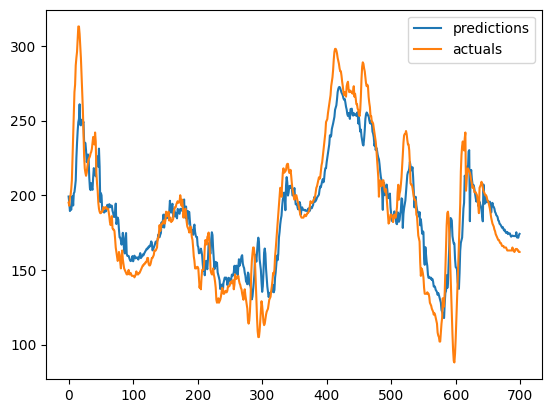

In [26]:
plt.plot(predictions[:700], label = 'predictions')
plt.plot(actuals[:700], label = 'actuals')
plt.legend()

# Testing

In [5]:
def test_model(model, test_step_updated_segments):

    # Prepare for training
    features_list_test, labels_list_test, raw_glu_list_test = prepare_dataset(test_step_updated_segments, 6, 6)

    # Build training and validation loader
    features_array_test = np.array(features_list_test)
    labels_array_test = np.array(raw_glu_list_test) # Maybe need to replace this

    X_test, y_test = features_array_test, labels_array_test

    # Data Preparation (assuming X_train, y_train, X_val, y_val are numpy arrays)
    X_test = torch.tensor(X_test, dtype=torch.float32)
    y_test = torch.tensor(y_test, dtype=torch.float32)

    # Create DataLoader
    test_dataset = TensorDataset(X_test, y_test)
    test_loader = DataLoader(test_dataset, batch_size=128, shuffle=False)

    model.eval()
    predictions = []
    actuals = []
    with torch.no_grad():
        for inputs, targets in test_loader:
            inputs, targets = inputs.to(device), targets.to(device)
            outputs = model(inputs)
            predictions.append(outputs)
            actuals.append(targets)

    predictions = torch.cat(predictions).cpu().numpy()
    actuals = torch.cat(actuals).cpu().numpy()

    rmse = root_mean_squared_error(actuals,predictions)
    print(f'RMSE on validation set: {rmse}')
    
    return predictions, actuals, rmse

In [10]:
# load model from .pth
model_dir = "./processed_data/stacked_lstm_model_6_6.pth"
input_size = 4 # Number of input features
hidden_size = 128  # Hidden vector size
num_layers = 2  # Number of LSTM layers
output_size = 1  # Single output
dropout_prob = 0.2  # Dropout probability

model = StackedLSTM(input_size, hidden_size, num_layers, output_size, dropout_prob) # input_size, hidden_size, num_layers, output_size, dropout_prob
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.00005)

model.load_state_dict(torch.load(model_dir))

/scratch/ipykernel_2441489/1076749343.py:13: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(model_dir))


<All keys matched successfully>

In [11]:
import glob




preds = []
trues = []
errors = []
fname = []

for file in glob.glob("./processed_data/*test*"):
    test_filename = file
    with open(test_filename, 'rb') as f:
        test_loaded_df_dict = pickle.load(f)

    # Verify the content
    test_step_updated_segments = test_loaded_df_dict
    pred, true, rmse = test_model(model, test_step_updated_segments)
    preds.append(pred)
    trues.append(true)
    errors.append(rmse)
    fname.append(file.split('/')[-1].split('_')[0])

len of features_list 2393
len of labels_list 2393
RMSE on validation set: 28.529722213745117
len of features_list 2716
len of labels_list 2716
RMSE on validation set: 27.53521728515625
len of features_list 2635
len of labels_list 2635
RMSE on validation set: 25.20589828491211
len of features_list 2537
len of labels_list 2537
RMSE on validation set: 23.448461532592773
len of features_list 2758
len of labels_list 2758
RMSE on validation set: 22.671024322509766
len of features_list 2480
len of labels_list 2480
RMSE on validation set: 30.21184539794922


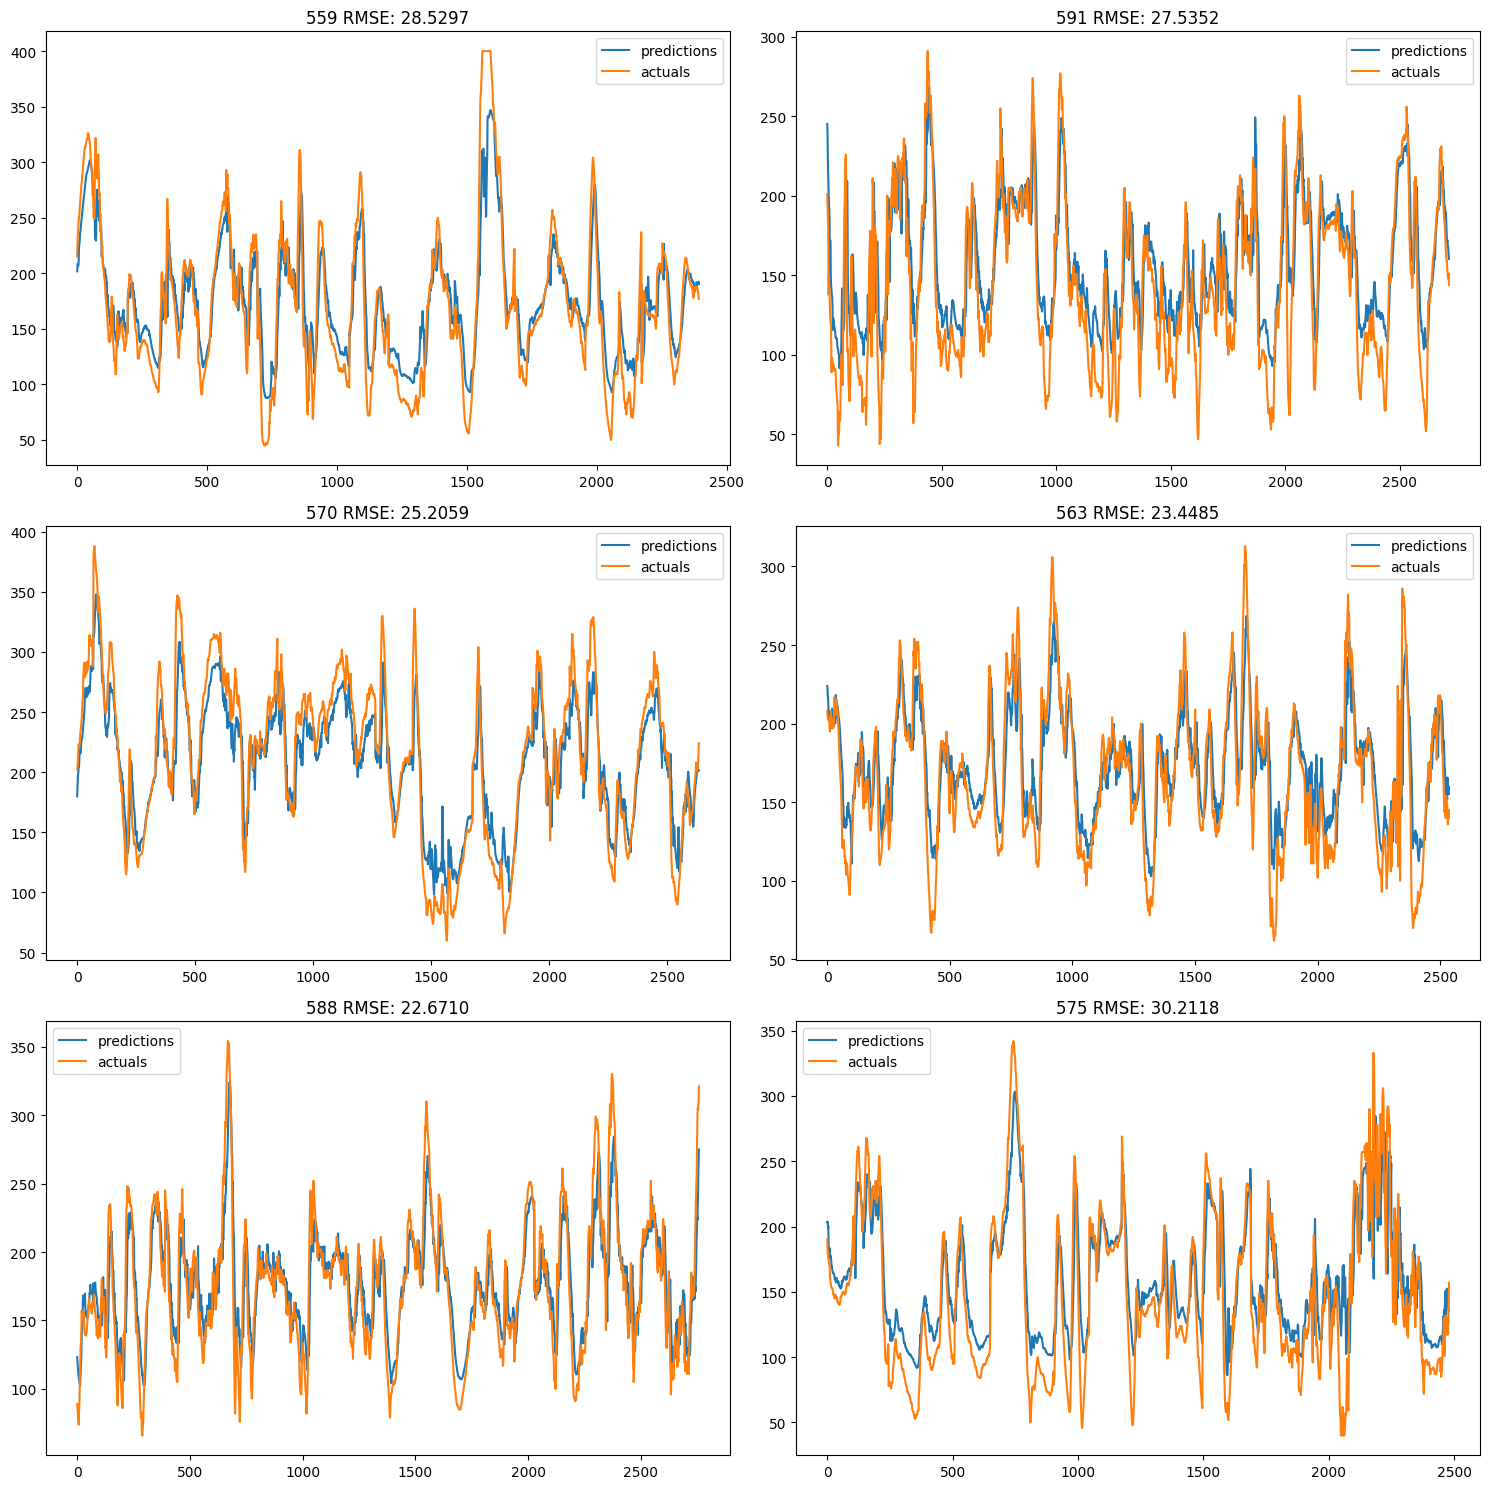

In [48]:
# make a 3x 2 plot and plot the preds and actuals of each one in each and have the title be the filename and the rmse

fig, axs = plt.subplots(3, 2, figsize=(15, 15))

for i in range(3):
    for j in range(2):
        idx = i*2 + j
        axs[i, j].plot(preds[idx], label = 'predictions')
        axs[i, j].plot(trues[idx], label = 'actuals')
        axs[i, j].legend()
        axs[i, j].set_title(f'{fname[idx]} RMSE: {errors[idx]:.4f}')
        
plt.tight_layout()

In [50]:
# convert this all to a table 
# save the table as a csv
# convert the fname and the rmse to a dataframe
pd.DataFrame({'fname': fname, 'rmse': errors}).to_csv('./')

,fname,rmse
0,559,28.529722
1,591,27.535217
2,570,25.205898
3,563,23.448462
4,588,22.671024
5,575,30.211845


In [27]:
# Prepare for training
features_list_test, labels_list_test, raw_glu_list_test = prepare_dataset(test_step_updated_segments, 6, 6)

# Build training and validation loader
features_array_test = np.array(features_list_test)
labels_array_test = np.array(raw_glu_list_test) # Maybe need to replace this

X_test, y_test = features_array_test, labels_array_test

# Data Preparation (assuming X_train, y_train, X_val, y_val are numpy arrays)
X_test = torch.tensor(X_test, dtype=torch.float32)
y_test = torch.tensor(y_test, dtype=torch.float32)

# Create DataLoader
test_dataset = TensorDataset(X_test, y_test)
test_loader = DataLoader(test_dataset, batch_size=128, shuffle=False)

len of features_list 2393
len of labels_list 2393


In [28]:
model.eval()
predictions = []
actuals = []
with torch.no_grad():
    for inputs, targets in test_loader:
        inputs, targets = inputs.to(device), targets.to(device)
        outputs = model(inputs)
        predictions.append(outputs)
        actuals.append(targets)

predictions = torch.cat(predictions).cpu().numpy()

actuals = torch.cat(actuals).cpu().numpy()


rmse = root_mean_squared_error(actuals,predictions)
print(f'RMSE on validation set: {rmse}')

RMSE on validation set: 28.529722213745117


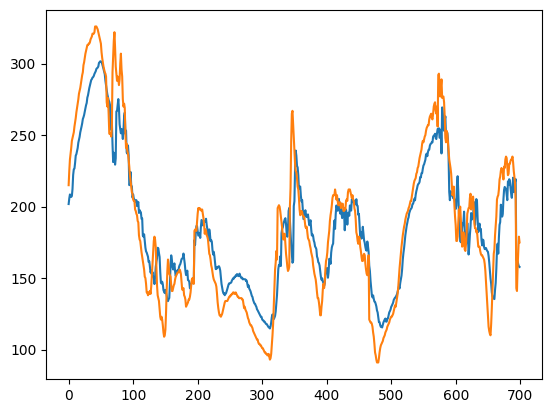

In [29]:
plt.plot(predictions[:700])
plt.plot(actuals[:700])